# AS - TME7
2018--2019

---

Binome : Juliette Ortholand, Stieban Fernandez

Modèles de séquence (réccurents)
- Modèle sur les caractères (prédire classe)
- Modèle génératif

Données Page AS@DAC
-> names (classes) :
- english.txt
- french.txt
- italian.txt
- ...

Chaque caractère en 1-hot -> char-embedding

Etat précédent : s0 s1, s2, ... application d'une fonction f

+

Classifieur

On travaille avec des batchs

-> remplir caractère vide par 0 par ex

---

Pour les modèles génératifs : longueur du prénom + 1 caractère pour déterminer la fin de la chaine :

Appliquer un masque : 1 s'il y a un caractère (+ caractère de fin) sinon 0

-> Prédire à chaque fois l'état (/caractère) suivant.

Utilisation : 
- Est-ce que "Pierre" est un prénom anglais ? (Calcul de la vraisemblance)
- Générer des prénoms

---

Parcourir les fichiers du répértoire avec glob('*.txt')

## Préparation des données

In [2]:
import torch
import torch.nn as nn
from unidecode import unidecode

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

In [3]:
from pathlib import Path

#-------------------------------------------------------
# Extraction des noms et labels
#-------------------------------------------------------
gen = Path("data/names").glob("*.txt")

L = [] # [(nom, pays), ...]
D = {} # {label(int): pays, ...}
for label, file in enumerate(gen):
    D[label] = file.stem
    
    with open(str(file), "r", encoding="utf-8") as f:
        names = f.read().split("\n")[:-1]
    for name in names:
        # Nettoyage
        name = "".join([c for c in unidecode(name.lower()) if c.isalpha()])
        L.append((name, label))

#-------------------------------------------------------
# Encodage
#-------------------------------------------------------
N = 27 # nombre de caractères différents pour le one hot

code_char = lambda x: ord(x)-96

decode_char = lambda x: chr(x+96)

def encode_name(name, N, M=None):
    # N : taille d'un vecteur one hot
    # M : padding
    res = torch.zeros((M if M!=None and M>len(name) else len(name)))
    #res = torch.zeros((M if M!=None and M>len(name) else len(name)), N)
    for i, c in enumerate(name):
        res[i] = code_char(c)
        #res[i, code_char(c)] = 1
    res[len(name):] = 1
    #res[len(name):, 0] = 1
    return res

def decode_name(indxs):
    return "".join([decode_char(indx) for indx in indxs if indx!=1])
    #return "".join([decode_char(indx.argmax()) for indx in indxs if indx[0]!=1])

#-------------------------------------------------------
# Construction du DataSet 
#-------------------------------------------------------
class NameDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        name, label = self.data[index]
        return encode_name(name, N), int(label)
    
    def __len__(self):
        return len(self.data)
    
#-------------------------------------------------------
# DataLoader
#-------------------------------------------------------

def collate_fn(sequences):
    length = max([len(x[0]) for x in sequences])
    data = torch.zeros(len(sequences), length)
    #data = torch.zeros(len(sequences), length, N)
    target = torch.zeros(len(sequences))
    for i, (name, label) in enumerate(sequences):
        data[i, :len(name)] = name
        #data[i, len(name):, 0] = 1 # padding pour s'adapter aux dimensions du batch
        data[i, len(name):] = 1
        target[i] = label
    return data, target
        
    
def get_data_loader(dataset, batch_size):
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, \
                         collate_fn=collate_fn)

#-------------------------------------------------------
# Split Train Val
#-------------------------------------------------------

import numpy as np
from sklearn.model_selection import train_test_split

X, y = np.array(L).T
Xtrain, Xval, ytrain, yval = train_test_split(X, y)

train_set = NameDataset(np.vstack((Xtrain, ytrain)).T)
val_set = NameDataset(np.vstack((Xval, yval)).T)

train_iter = get_data_loader(train_set, 150)
val_iter = get_data_loader(val_set, 150)

In [4]:
decode_name(encode_name("pierre", N, 19))

'pierre'

In [5]:
for x, y in train_iter:
    ex, lab = x, y
    print(x.shape, y.shape)

torch.Size([150, 13]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 12]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 13]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 13]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 12]) torch.Size([150])
torch.Size([150, 15]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 13]) torch.Size([150])
torch.Size([150, 19]) torch.Size([150])
torch.Size([150, 13]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 16]) torch.Size([150])
torch.Size([150, 12]) torch.Size([150])
torch.Size([150, 11]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])
torch.Size([150, 13]) torch.Size([150])
torch.Size([150, 14]) torch.Size([150])


---

## Construction du modèle

In [18]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.emb = nn.Embedding(27,input_size)
        
        self.linx = nn.Linear(input_size, hidden_size)
        self.linh = nn.Linear(hidden_size, hidden_size)
        self.activ = nn.ReLU()
        self.liny = nn.Linear(hidden_size, output_size)
        
    def forward(self, seq):
        # seq : (seq_length, batch_size)
        
        emb_seq = self.emb(seq)
        output = self.initHidden()
        
        for _input in emb_seq:
            output = self.activ(self.linx(_input) + self.linh(output))
        output = self.liny(output)
        
        return output

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

input_size, hidden_size, output_size = 50, 110, len(D)
model = RNN(input_size, hidden_size, output_size)

In [12]:
# TEST

out = model(ex.transpose(0,1).long())

for i, e in enumerate(out):
    print(decode_name(ex[i]), ":", D[e.argmax().item()])

torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
torch.Size([55, 50])
lyrschikov : Vietnamese
gn : Vietnamese
bsr : Vietnamese
trukhnin : Vietnamese
stroggylis : Vietnamese
okzwy : Vietnamese
tiyeh : Vietnamese
wirth : Vietnamese
durnd : Vietnamese
tugi : Vietnamese
ykubonis : Vietnamese
gnem : Vietnamese
kempf : Vietnamese
preece : Vietnamese
ykovkin : Vietnamese
bt : Vietnamese
koustoubos : Vietnamese
curtis : Vietnamese
sntoro : Vietnamese
jblontzev : Vietnamese
dovbyschuk : Vietnamese
boutros : Vietnamese
hnrets : Vietnamese
mumldze : Vietnamese
greenwy : Vietnamese
slib : Vietnamese
pennders : Vietnamese
bvin : Vietnamese
lmill : Vietnamese
judelevich : Vietnamese
wtters : Vietnamese
vinnitsky : Vietnamese
mozhrtsev : Vietnamese
rodriguez : Vietnamese
stevenson : Vietnamese
guirguis : Vietnamese
brhm :

---

## Classification

In [25]:
model = RNN(input_size, hidden_size, output_size)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

def accuracy(ypred, y):
    ### Calcul du score
    return (ypred.argmax(dim=1) == y).float().mean()

def fit_eval_rnn(model, loss, optim, train_iter, val_iter, n_epochs):
    train_loss = []
    train_score = []
    val_loss = []
    val_score = []

    ### APPRENTISSAGE
    #--------------------------------------------------------
    for i in range(n_epochs):
        
        model.train()
        ####### TRAIN #######
        costs_train = []
        scores_train = []
        for x, l in train_iter:

            x = x.transpose(0,1).long()
            l = l.long()

            out = model(x)
            cost = loss(out, l)
            optim.zero_grad()
            cost.backward()
            optim.step()

            costs_train.append(cost)
            scores_train.append(accuracy(out, l))

        train_loss.append(torch.tensor(costs_train).mean())
        train_score.append(torch.tensor(scores_train).mean())

        model.eval()
        ####### VALID #######
        costs_val = []
        scores_val = []
        for x, l in val_iter:
            x = x.transpose(0,1).long()
            l = l.long()

            out = model(x)
            cost = loss(out, l)

            costs_val.append(cost)
            scores_val.append(accuracy(out, l))

        val_loss.append(torch.tensor(costs_val).mean())
        val_score.append(torch.tensor(scores_val).mean())
        
    return train_loss, val_loss, train_score, val_score


def show_loss_score(train_loss, val_loss, train_score, val_score):
    ### AFFICHAGE LOSS ET SCORE
    #--------------------------------------------------------
    plt.figure(figsize=(10,7))
    plt.plot(train_loss, c="red", label="train")
    plt.plot(val_loss, c="b", label="val")
    plt.legend(loc="best")
    plt.show()

    plt.figure(figsize=(10,7))
    plt.plot(train_score, c="red", label="train")
    plt.plot(val_score, c="b", label="val")
    plt.legend(loc="best")
    plt.show()

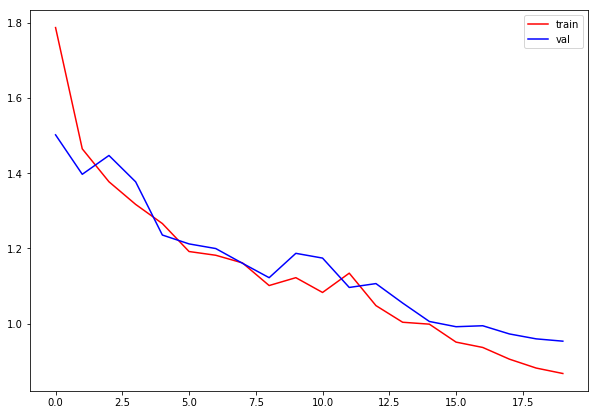

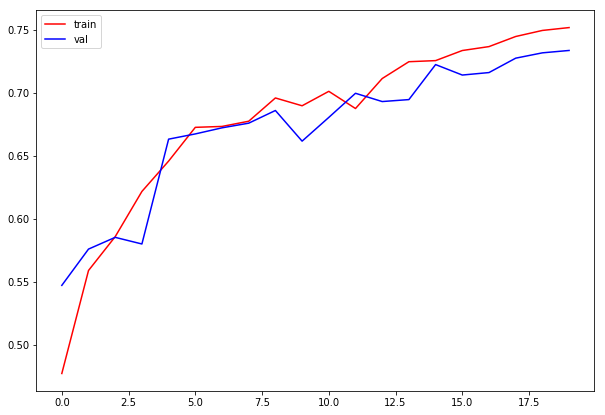

In [26]:
res = fit_eval_rnn(model, loss, optim, train_iter, val_iter, n_epochs)
show_loss_score(*res)

In [32]:
import collections

collections.Counter(list(ytrain)+list(yval))

Counter({'4': 3668,
         '14': 9408,
         '0': 2000,
         '6': 724,
         '3': 297,
         '8': 232,
         '2': 519,
         '5': 277,
         '10': 991,
         '16': 298,
         '12': 139,
         '7': 203,
         '1': 268,
         '11': 94,
         '9': 709,
         '15': 100,
         '17': 73,
         '13': 74})

Résultat biaisé car certaines classes contiennent plus d'exemples que d'autres

--> Preprocessing nécessaire : rebalancage des classes pour l'apprentissage

## Génération